In [1]:
# Linear Regression applied to Station Observations for Graz

In [2]:
# Import packages / libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sym
import sympy.printing as printing
from scipy.stats import f
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

In [31]:
# Read the CSV file initially
df = pd.read_csv("Data/Station_Obs_Graz.csv", header=0, dtype={"Date": np.int64}, sep=';')

# Print the dataframe
print(df.columns)


Index(['Date', 'RR', 'DD', 'FF', 'FFX', 'PP', 'PP0', 'RAD', 'RH', 'TF', 'TT',
       'TT5', 'TD', 'TX', 'TN', 'SO'],
      dtype='object')


In [32]:
# Create DateTime Object from numerical Timestamp using to_datetime with format %Y%m%d%H%M
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d%H%M')

# Create DateTime Object from numerical Timestamp
df['Date'] = pd.to_datetime(df['Date']) #, unit='s')

# Set Date Column to Index
df.set_index('Date', inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Print the dataframe
print(df)

                      RR   DD  FF  FFX     PP     PP0  RAD    RH   TF   TT  \
Date                                                                         
2013-01-01 00:00:00  0.0   30   1  3.0  973.5  1020.7  0.0  96.0 -2.4 -2.1   
2013-01-01 01:00:00  0.0   40   1  2.0  973.0  1020.2  0.0  96.0 -2.4 -2.1   
2013-01-01 02:00:00  0.0  110   1  2.0  972.4  1019.6  0.0  96.0 -2.6 -2.3   
2013-01-01 03:00:00  0.0   60   1  2.0  971.5  1018.7  0.0  97.0 -3.0 -2.8   
2013-01-01 04:00:00  0.0   60   2  3.0  970.7  1017.9  0.0  97.0 -3.2 -3.0   
...                  ...  ...  ..  ...    ...     ...  ...   ...  ...  ...   
2013-12-31 20:00:00  0.0  160   1  2.0  976.7  1023.0  0.0  92.0  2.8  3.6   
2013-12-31 21:00:00  0.0  160   1  2.0  976.3  1022.6  0.0  92.0  2.7  3.5   
2013-12-31 22:00:00  0.0  120   1  2.0  975.8  1022.1  0.0  93.0  2.8  3.5   
2013-12-31 23:00:00  0.0  130   1  2.0  975.3  1021.6  0.0  93.0  2.8  3.4   
2014-01-01 00:00:00  0.0  160   2  4.0  975.1  1021.4  0.0  92.0

In [33]:
# Compute Correlations between all variables ("TT5","RR","FF","FFX","PP","RAD","RH","TT","TF","TD","SO")
# Select the columns
columns = ["TT5","RR","FF","FFX","PP","RAD","RH","TT","TF","TD","SO"]

# Compute correlations
correlations = df[columns].corr()

print(correlations)

          TT5        RR        FF       FFX        PP       RAD        RH  \
TT5  1.000000 -0.010561  0.240636  0.310214  0.064820  0.745255 -0.640184   
RR  -0.010561  1.000000  0.044119  0.095313 -0.073461 -0.071540  0.138882   
FF   0.240636  0.044119  1.000000  0.825780 -0.111095  0.230990 -0.442096   
FFX  0.310214  0.095313  0.825780  1.000000 -0.141089  0.335698 -0.561012   
PP   0.064820 -0.073461 -0.111095 -0.141089  1.000000  0.051142 -0.073710   
RAD  0.745255 -0.071540  0.230990  0.335698  0.051142  1.000000 -0.670909   
RH  -0.640184  0.138882 -0.442096 -0.561012 -0.073710 -0.670909  1.000000   
TT   0.928258 -0.008804  0.236503  0.282181  0.091761  0.543274 -0.619776   
TF   0.854860  0.038177  0.111948  0.121449  0.083069  0.378018 -0.361429   
TD   0.740432  0.073084  0.005760 -0.014024  0.070426  0.222195 -0.132705   
SO   0.566679 -0.080661  0.176240  0.262015  0.116922  0.822215 -0.627751   

           TT        TF        TD        SO  
TT5  0.928258  0.854860  0.74

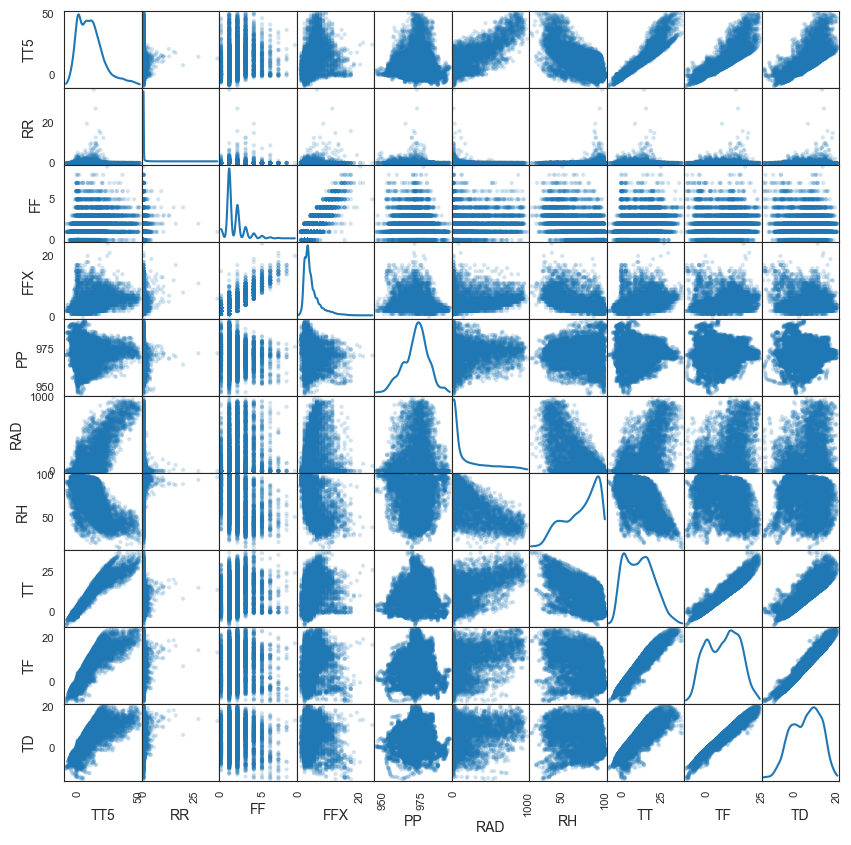

In [34]:
# Create pairwise Scatterplot with density plot in diagonal 
# Use scatter_matrix command from pandas

# Create a scatter matrix
pd.plotting.scatter_matrix(df[columns], alpha=0.2, figsize=(10, 10), diagonal='kde')

# Show the plot
plt.show()

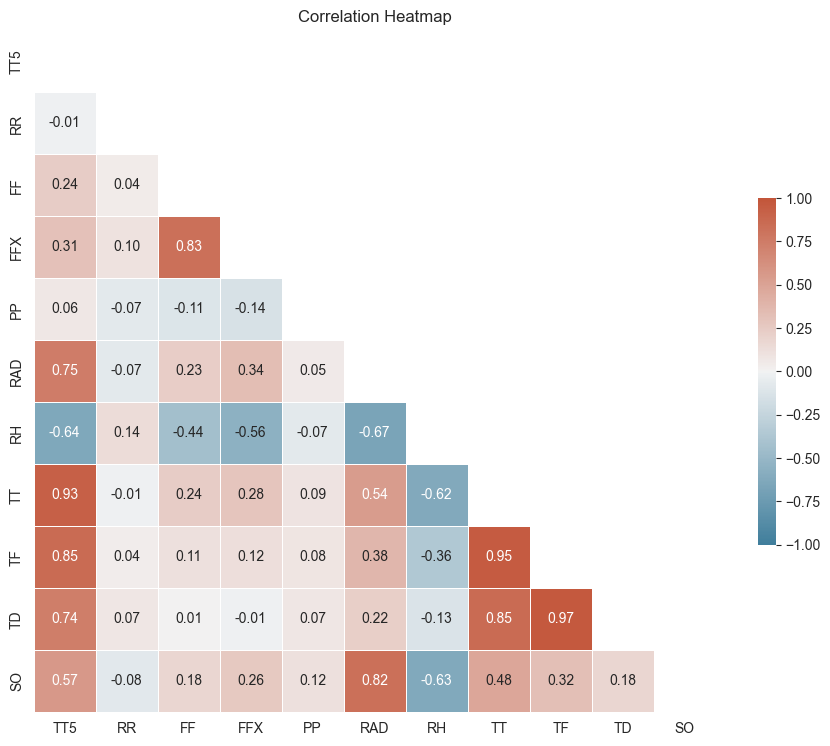

In [35]:
# Correlation Plot with seaborn
# use white style
sns.set_style("white")

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Use a diverging colormap 
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Draw the seaborn heatmap with the mask and correct aspect ratio
# Add correlation results to heatmap
# limit color range to -1 to 1
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# add title
plt.title('Correlation Heatmap')

plt.show()

In [40]:
# Create a StandardScaler object to scale predictors to mean 0 and variance 1
# Therefore, create a list with the predictor names whicht should be scaled ("RR","FF","FFX","PP","RAD","RH","TT","TD","TF","SO")
# Fit the scaler to the dataframe columns
# Transform the selected columns using the scaler
# create new dataframe containing the scaled predictors
# add the Date column from original dataframe into new dataframe
# Set Date column to index
# Append also predictand TT5 to this dataframe

# Create a StandardScaler object
scaler = StandardScaler()

# Create a list with the predictor names which should be scaled
predictors = ["RR","FF","FFX","PP","RAD","RH","TT","TD","TF","SO"]

# Fit the scaler to the dataframe columns
scaler.fit(df[predictors])

# Transform the selected columns using the scaler
scaled_values = scaler.transform(df[predictors])

# Create new dataframe containing the scaled predictors
df_scaled = pd.DataFrame(scaled_values, columns=predictors)

# Add the Date column from original dataframe into new dataframe
df_scaled["Date"] = df.index

# Set Date column to index
df_scaled.set_index('Date', inplace=True)

# Append also predictand TT5 to this dataframe
df_scaled['TT5'] = df['TT5']

df_scaled.dropna(inplace=True)

In [41]:
# Assign predictand TT5 to variable y
y = df_scaled['TT5']

# Assign predictors to Matrix X
X = df_scaled.drop('TT5', axis=1)

# Split Data in Training- and Test Data, use 25% of data for test purpose, 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train linear regression with trainingsdata using LinearRegression()
model = LinearRegression()
model.fit(X_train, y_train)

# Predict y for training and test dataset (y hat variables)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


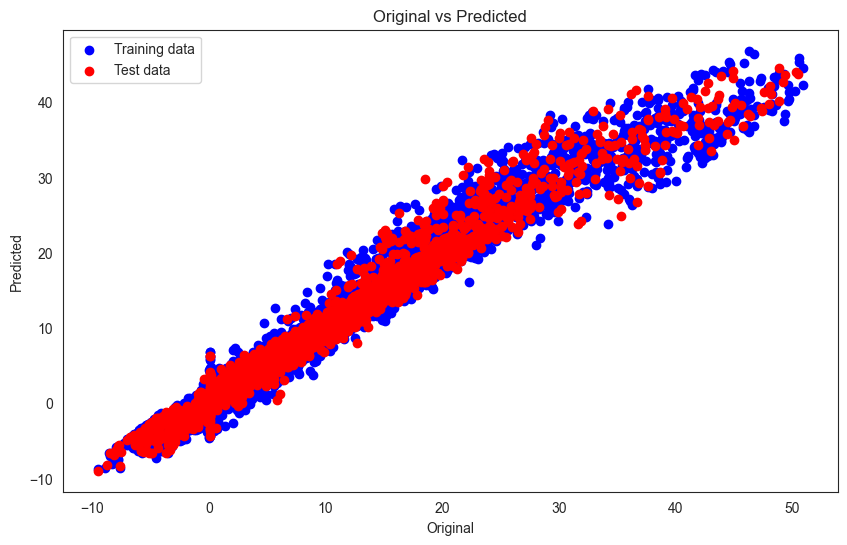

In [42]:
# Draw a Scatterplot for original (y) and modelled (y hat) predictand 
# Plot results for training- and testdata in same scatterplot using different colors
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Training data')
plt.scatter(y_test, y_test_pred, color='red', label='Test data')

# Add xlabel, ylabel and a title
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.title('Original vs Predicted')

# Add a legend
plt.legend()

plt.show()

In [43]:
# Computation of Verification Scores
# BIAS, MAE, MSE, RMSE, R² (explained Variance) for Test and Training Data
# print results as Text

# Compute verification scores for training data
bias_train = y_train_pred - y_train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train**0.5
r2_train = explained_variance_score(y_train, y_train_pred)

# Compute verification scores for test data
bias_test = y_test_pred - y_test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mse_test**0.5
r2_test = explained_variance_score(y_test, y_test_pred)

# Print results
print("Training data:")
print(f"BIAS: {bias_train.mean()}, MAE: {mae_train}, MSE: {mse_train}, RMSE: {rmse_train}, R²: {r2_train}")
print("Test data:")
print(f"BIAS: {bias_test.mean()}, MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}, R²: {r2_test}")

Training data:
BIAS: 2.6259662100325325e-15, MAE: 1.4117999828143537, MSE: 4.239622138048261, RMSE: 2.0590342731601776, R²: 0.9624654136914672
Test data:
BIAS: 0.05489128084719022, MAE: 1.432315562484084, MSE: 4.504057501323725, RMSE: 2.122276490310281, R²: 0.9614152083945685


In [44]:
# Optional: Calculate coefficients (beta) and standard errors (sigma hat, se hat, z values) manually (Slide 7 and 8 from Presentation_05_Lin_Reg.pdf)

# Add a column of ones to X for the intercept
X = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

# Calculate beta
beta = np.linalg.inv(X.T @ X) @ X.T @ y_train

# Calculate residuals
residuals = y_train - X @ beta

# Calculate sigma^2
sigma2 = np.var(residuals, ddof=X.shape[1])

# Calculate standard errors
se = np.sqrt(np.diag(np.linalg.inv(X.T @ X)) * sigma2)

# Calculate z values
z = beta / se

# Print results
print(f"beta: {beta}")
print(f"se: {se}")
print(f"z: {z}")

beta: [10.76966916  0.07653647 -0.07788243  0.15293275 -0.02319115  5.80933154
  0.78219271  5.8595958  -2.55870717  4.78772482 -2.11909758]
se: [0.02553217 0.0312226  0.04570257 0.05153447 0.02645464 0.04995181
 0.13973929 2.90887841 3.69029435 6.34108117 0.04621548]
z: [421.8078315    2.45131602  -1.70411489   2.96758157  -0.87663803
 116.29872754   5.59751438   2.0143832   -0.69336127   0.75503289
 -45.85254939]


In [45]:
# Optional: Create a table (pandas dataframe) with the results and print results 
results = pd.DataFrame({
    'beta': beta,
    'se': se,
    'z': z
}, index=['Intercept'] + predictors)

print(results)


                beta        se           z
Intercept  10.769669  0.025532  421.807831
RR          0.076536  0.031223    2.451316
FF         -0.077882  0.045703   -1.704115
FFX         0.152933  0.051534    2.967582
PP         -0.023191  0.026455   -0.876638
RAD         5.809332  0.049952  116.298728
RH          0.782193  0.139739    5.597514
TT          5.859596  2.908878    2.014383
TD         -2.558707  3.690294   -0.693361
TF          4.787725  6.341081    0.755033
SO         -2.119098  0.046215  -45.852549


In [51]:
# Optional: Computation of F statistic for full and reduced model (equations from slide 9)
# reduced model consists of TT and RAD only

from sklearn.feature_selection import f_regression

# Full model
F, p = f_regression(X_train, y_train)
print("Full model:")
print(f"F-statistics: {F}")
print(f"p-values: {p}")

# Reduced model
X_reduced = X_train[['TT', 'RAD']]
X_test_reduced = X_test[['TT', 'RAD']]
model.fit(X_reduced, y_train)
F_reduced, p_reduced = f_regression(X_reduced, y_train)
y_train_pred_reduced = model.predict(X_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)
print("\nReduced model:")
print(f"F-statistics: {F_reduced}")
print(f"p-values: {p_reduced}")

# Calculate the residual sum of squares (RSS) and the total sum of squares(TSS) of the full model
# Calculate F-statistics for full model (test if at least one weight is significantly different from zero)
residuals_full = y_train - y_train_pred
RSS_full = np.sum(residuals**2)
TSS_full = np.sum((y_train - y_train.mean())**2)

residuals_reduced = y_train - y_train_pred_reduced
RSS_reduced = np.sum(residuals_reduced**2)
TSS_reduced = np.sum((y_train - y_train.mean())**2)


# F-Test can be done using scipy.stats (computing critical F-values to compare with calculated F values)
df_full = len(y_train) - len(beta)
df_reduced = len(y_train) - 2  # Only 'TT' and 'RAD' in the reduced model
F_stat = ((RSS_reduced - RSS_full) / (df_reduced - df_full)) / (RSS_full / df_full)

# Print results to screen
print(f"F-statistic: {F_stat}")
print(f"p-value full: {p}")
print(f"p-value reduced: {p_reduced}")

Full model:
F-statistics: [9.07789193e-01 3.97989893e+02 7.06364402e+02 3.26448923e+01
 8.12093495e+03 4.47207091e+03 3.99901735e+04 7.90462863e+03
 1.75931725e+04 3.00195911e+03]
p-values: [3.40737039e-001 5.34886436e-086 7.46672776e-148 1.15516689e-008
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]

Reduced model:
F-statistics: [39990.173494    8120.93495033]
p-values: [0. 0.]
F-statistic: 359.1392167390562
p-value full: [3.40737039e-001 5.34886436e-086 7.46672776e-148 1.15516689e-008
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
p-value reduced: [0. 0.]


In [106]:
# Best subset selection
# Start with model with intercept only (predictor matrix is column vector with values 1 only)

# Compute RSS for training- and MSE for testdata, store values in a list

# Implement Algorithm from slide 16
# compute all combinations
# Hints: use itertools.combinations to compute all combinations from a list with i items
# Split Data in Training- and Test Data
# Train model with selected feature combination
# predict surface temperature for training and test dataset
# Collect all MSE and RSS values for plotting, note minimal values for each number of predictors

# Start with all possible combinations

# Initialize lists to store results
rss_train = []
mse_test = []
best_features = []
rss_x = []
rss_y = []
mse_x = []
mse_y = []

# Get all combinations of features
all_features = X_train.columns
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(itertools.combinations(all_features, i))

# Loop over all combinations of features
for features in feature_combinations:
    features = list(features)

    # Train model with selected feature combination
    model = LinearRegression()
    model.fit(X_train[features], y_train)

    # Predict surface temperature for training and test dataset
    y_train_pred = model.predict(X_train[features])
    y_test_pred = model.predict(X_test[features])

    # Compute RSS for training data and MSE for test data
    rss = np.sum((y_train - y_train_pred)**2)
    mse = mean_squared_error(y_test, y_test_pred)

    rss_x.append(len(features))
    rss_y.append(rss)
    mse_x.append(len(features))
    mse_y.append(mse)

    # Store results
    rss_train.append(rss)
    mse_test.append(mse)

    # If this is the best MSE so far, store the feature combination
    if mse == min(mse_test):
        best_features = features

# Print best feature combination
print(f"Best feature combination: {best_features}")


Best feature combination: ['RR', 'FF', 'FFX', 'PP', 'RAD', 'RH', 'TT', 'SO']


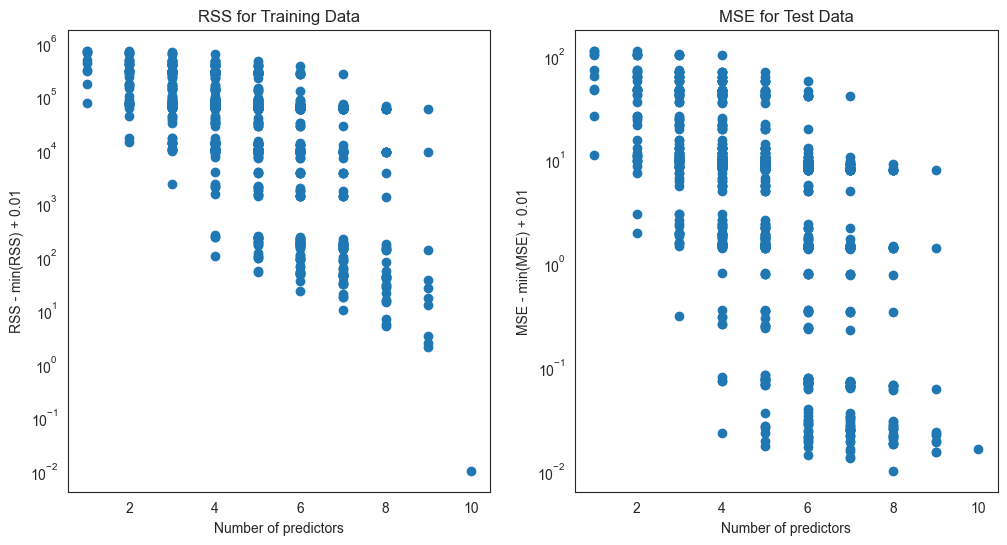

In [112]:
# use RSS - min(RSS) + 0.01 and MSE - min(MSE) + 0.01 for y-axis 
# add titles, x- and ylabels and add combination of predictors with minimal test error in overall title 

# Create a plot with the results from best subset selection like in slide 17

# Left subplot contains RSS for Training data, right subplot MSE for Testdata

# Compute minimum RSS and MSE
min_rss = min(rss_train)
min_mse = min(mse_test)

rss_y_adjusted = np.zeros(len(rss_y))
mse_y_adjusted = np.zeros(len(mse_y))

# Compute adjusted RSS and MSE
for i in range(len(rss_y)):
    rss_y_adjusted[i] = rss_y[i] - min_rss + 0.01

for i in range(len(mse_y)):
    mse_y_adjusted[i] = mse_y[i] - min_mse + 0.01


# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plt.semilogy()

# Plot adjusted RSS
ax[0].scatter(rss_x, rss_y_adjusted, marker='o')
ax[0].set_xlabel('Number of predictors')
ax[0].set_ylabel('RSS - min(RSS) + 0.01')
ax[0].set_title('RSS for Training Data')
ax[0].set_yscale('log')

# Plot adjusted MSE
ax[1].scatter(mse_x, mse_y_adjusted, marker='o')
ax[1].set_xlabel('Number of predictors')
ax[1].set_ylabel('MSE - min(MSE) + 0.01')
ax[1].set_title('MSE for Test Data')
ax[1].set_yscale('log')

# Show plots
plt.show()

In [17]:
# Optional: Forward Stepwise Subset Selection
# Implement algorithm from Slide 18
# Start with model with intercept only
# Loop over number of predictors



In [63]:
# Forward Stepwise Selection

# Initialize lists to store results
rss_train = []
mse_test = []
best_features_fss = []

# Initialize list of selected features
selected_features = []

# Loop over all features
for i in range(len(all_features)):
    remaining_features = list(set(all_features) - set(selected_features))

    # Initialize best MSE
    best_mse = np.inf

    # Loop over remaining features
    for feature in remaining_features:
        # Train model with selected feature combination
        model = LinearRegression()
        model.fit(X_train[selected_features + [feature]], y_train)

        # Predict surface temperature for training and test dataset
        y_train_pred = model.predict(X_train[selected_features + [feature]])
        y_test_pred = model.predict(X_test[selected_features + [feature]])

        # Compute RSS for training data and MSE for test data
        rss = np.sum((y_train - y_train_pred)**2)
        mse = mean_squared_error(y_test, y_test_pred)

        # If this is the best MSE so far, store the feature and the MSE
        if mse < best_mse:
            best_mse = mse
            best_feature = feature

    # Add best feature to selected features
    selected_features.append(best_feature)

    # Store results
    rss_train.append(rss)
    mse_test.append(best_mse)
    best_features_fss = selected_features.copy()
    # best_features_fss = best_features_fss[np.argmin(mse_test)]

# Print best feature combination
print(f"Best feature combination: {best_features_fss}")

Best feature combination: ['TT', 'RAD', 'SO', 'RH', 'PP', 'RR', 'FFX', 'FF', 'TD', 'TF']


In [68]:
# Backward Stepwise Selection

# Initialize lists to store results
rss_train = []
mse_test = []
best_features_bss = []

# Initialize list of selected features
selected_features = list(all_features)

# Loop over all features
for i in range(len(all_features)-1):
    # Initialize best MSE
    best_mse = np.inf

    # Loop over selected features
    for feature in selected_features:
        # Train model with selected feature combination
        model = LinearRegression()
        model.fit(X_train[list(set(selected_features) - set([feature]))], y_train)

        # Predict surface temperature for training and test dataset
        y_train_pred = model.predict(X_train[list(set(selected_features) - set([feature]))])
        y_test_pred = model.predict(X_test[list(set(selected_features) - set([feature]))])

        # Compute RSS for training data and MSE for test data
        rss = np.sum((y_train - y_train_pred)**2)
        mse = mean_squared_error(y_test, y_test_pred)

        # If this is the best MSE so far, store the feature and the MSE
        if mse < best_mse:
            best_mse = mse
            worst_feature = feature

    # Remove worst feature from selected features
    selected_features.remove(worst_feature)

    # Store results
    rss_train.append(rss)
    mse_test.append(best_mse)
    best_features_bss.append(selected_features.copy())

best_features_bss = best_features_bss[np.argmin(mse_test)]

# Print best feature combination
print(f"Best feature combination: {best_features_bss}")

Best feature combination: ['RR', 'FF', 'FFX', 'PP', 'RAD', 'RH', 'TT', 'SO']


In [73]:
# Forward Stagewise Selection

# Initialize lists to store results
rss_train = []
mse_test = []
best_features_stage = []

# Initialize list of selected features
selected_features = []

# Initialize coefficients
coefficients = np.zeros(len(all_features))

# Standardize the predictors to have mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Loop until no predictors can improve the model
while len(selected_features) < len(all_features):
    # Initialize best MSE
    best_mse = np.inf

    # Loop over all features
    for i in range(len(all_features)):
        if i not in selected_features:
            # Add a small proportion of the predictor to the model
            coefficients[i] += 0.01

            # Predict surface temperature for training and test dataset
            y_train_pred = np.dot(X_train_scaled, coefficients)
            y_test_pred = np.dot(X_test_scaled, coefficients)

            # Compute RSS for training data and MSE for test data
            rss = np.sum((y_train - y_train_pred)**2)
            mse = mean_squared_error(y_test, y_test_pred)

            # If this is the best MSE so far, store the feature and the MSE
            if mse < best_mse:
                best_mse = mse
                best_feature = i

            # Subtract the small proportion of the predictor from the model
            coefficients[i] -= 0.01

    # Add best feature to selected features
    selected_features.append(best_feature)

    # Add a small proportion of the best predictor to the model
    coefficients[best_feature] += 0.01

    # Store results
    rss_train.append(rss)
    mse_test.append(best_mse)
    for i in selected_features:
        best_features_stage.append(all_features[i])

best_features_stage = best_features_stage[np.argmin(mse_test)]
# Print best feature combination
print(f"Best feature combination: {best_features_stage}")

Best feature combination: RAD


In [72]:
# Compare Selected Features of all Methods

print(f"Selection with Forward Stepwise: {best_features_fss}")
print(f"Selection with Backward Stepwise: {best_features_bss}")
print(f"Selection with Forward Stepwise: {best_features_stage}")

Selection with Forward Stepwise: ['FF', 'FFX', 'PP', 'RAD', 'RH', 'RR', 'SO', 'TD', 'TF', 'TT']
Selection with Backward Stepwise: ['FF', 'FFX', 'PP', 'RAD', 'RH', 'RR', 'SO', 'TT']
Selection with Forward Stepwise: RAD


In [18]:
# Optional: Plot results from Forward Stepwise Subset Selection like that in Slide 19
# Left subplot contains RSS for Training data, right subplot MSE for Testdata
# use RSS - min(RSS) + 0.01 and MSE - min(MSE) + 0.01 for y-axis 
# add titles, x- and ylabels and add combination of predictors with minimal test error in overall title 

